In [1]:
%cd E:\kaggle\iceberg

E:\kaggle\iceberg


In [16]:
import numpy as np
import pandas as pd
import cv2
import sys
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from os.path import join as opj
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.ndimage.filters import uniform_filter

from keras.optimizers import RMSprop
from keras.utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation
from keras.layers import *
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras import initializers
from keras.optimizers import Adam
from keras.optimizers import rmsprop
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

from keras.datasets import cifar10
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from keras.applications.xception import Xception
from keras.applications.mobilenet import MobileNet
from keras.applications.vgg19 import VGG19
from keras.layers import Concatenate, Dense, LSTM, Input, concatenate
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

#Data Aug for multi-input
from keras.preprocessing.image import ImageDataGenerator

batch_size=64

In [3]:
def display_img(band_1, band_2, is_iceberg, angle = None):
    if angle is None:
        title_str = 'Iceberg' if is_iceberg == 1 else 'Ship'
    else:
        title_str = 'Iceberg-' + str(angle) if is_iceberg == 1 else 'Ship-' + str(angle)
    fig = plt.figure(0, figsize=(10,10))
    ax = fig.add_subplot(1,2,1)
    ax.set_title(title_str + ' - Band 1')
    ax.imshow(band_1,cmap='jet')
    ax = fig.add_subplot(1,2,2)
    ax.set_title(title_str + ' - Band 2')
    ax.imshow(band_2,cmap='jet')
    plt.show()

# implement functions to convert SAR data from decibel units to linear units and back again
def decibel_to_linear(band):
     # convert to linear units
    return np.power(10,np.array(band)/10)

def linear_to_decibel(band):
    return 10*np.log10(band)

# implement the Lee Filter for a band in an image already reshaped into the proper dimensions
def lee_filter(band, window, var_noise = 0.25):
    # band: SAR data to be despeckled (already reshaped into image dimensions)
    # window: descpeckling filter window (tuple)
    # default noise variance = 0.25
    # assumes noise mean = 0
    
    mean_window = uniform_filter(band, window)
    mean_sqr_window = uniform_filter(band**2, window)
    var_window = mean_sqr_window - mean_window**2

    weights = var_window / (var_window + var_noise)
    band_filtered = mean_window + weights*(band - mean_window)
    return band_filtered

def apply_lee_filter(band_1_linear, band_2_linear, window_var_index = 0, noise_var_index = 0):
    windows = [2, 4, 8] # can be tuple too if not symetric
    noise_var = np.array([1, 2, 4])
    noise_var_1 = np.round(np.var(band_1_linear) * noise_var, 10)
    noise_var_2 = np.round(np.var(band_2_linear) * noise_var, 10)
    band_1_linear_filtered = lee_filter(band_1_linear, windows[window_var_index], noise_var_1[noise_var_index])
    band_2_linear_filtered = lee_filter(band_2_linear, windows[window_var_index], noise_var_2[noise_var_index])
    return band_1_linear_filtered, band_2_linear_filtered

def apply_lee_filter_single(band_linear, window_var_index = 0, noise_var_index = 0):
    windows = [2, 4, 8] # can be tuple too if not symetric
    noise_var = np.array([1, 2, 4])
    noise_var = np.round(np.var(band_linear) * noise_var, 10)
    band_linear_filtered = lee_filter(band_linear, windows[window_var_index], noise_var[noise_var_index])
    return band_linear_filtered

In [4]:
def np_get_scaled_band(band_list):
    imgs = []
    for band in band_list:        
#         imgs.append((band - band.mean()) / (band.max() - band.min()))
        imgs.append(band - band.mean())
    return np.array(imgs)

def get_more_images(imgs):
    more_images = []
    vert_flip_imgs = []
    hori_flip_imgs = []
    vh_flip_imgs = []
      
    for i in range(0,imgs.shape[0]):
        vert_flip_imgs.append(cv2.flip(imgs[i], 1))
        hori_flip_imgs.append(cv2.flip(imgs[i], 0))
        vh_flip_imgs.append(cv2.flip(imgs[i], -1))
      
    v = np.array(vert_flip_imgs)
    h = np.array(hori_flip_imgs)
    vh = np.array(vh_flip_imgs)
       
    more_images = np.concatenate((imgs,v,h, vh))
    
    return more_images

In [5]:
train = pd.read_json("E:/kaggle/iceberg/train.json/data/processed/train.json")
target_train = np.array(train['is_iceberg'])
test = pd.read_json("E:/kaggle/iceberg/test.json/data/processed/test.json")

In [6]:
# train['inc_angle']=pd.to_numeric(train['inc_angle'], errors='coerce')#We have only 133 NAs.
# test['inc_angle']=pd.to_numeric(test['inc_angle'], errors='coerce')
# train['inc_angle']=train['inc_angle'].fillna(method='pad')
train["inc_angle"] = train["inc_angle"].replace('na',0)
idx_tr = np.where(train["inc_angle"]>0)
train = train.iloc[idx_tr[0]]
target_train = target_train.iloc[idx_tr[0]]
test['inc_angle']=test['inc_angle'].fillna(method='pad')
X_angle=train['inc_angle']
X_test_angle=test['inc_angle']

In [7]:
#Generate the training data
X_band_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_1"]])
X_band_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_2"]])
#apply filter
X_band_1_filtered = np.array([apply_lee_filter_single(decibel_to_linear(band)) for band in X_band_1])
X_band_2_filtered = np.array([apply_lee_filter_single(decibel_to_linear(band)) for band in X_band_2])
X_band_1_filtered = linear_to_decibel(X_band_1_filtered)
X_band_2_filtered = linear_to_decibel(X_band_2_filtered)
X_band_1 = X_band_1_filtered
X_band_2 = X_band_2_filtered

X_band_3=np.fabs(np.subtract(X_band_1,X_band_2))
X_band_4=np.maximum(X_band_1,X_band_2)
X_band_5=np.minimum(X_band_1,X_band_2)
# subtract mean
X_band_3 = np_get_scaled_band(X_band_3)
X_band_4 = np_get_scaled_band(X_band_4)
X_band_5 = np_get_scaled_band(X_band_5)
    
X_train = np.concatenate([X_band_3[:, :, :, np.newaxis],X_band_4[:, :, :, np.newaxis],X_band_5[:, :, :, np.newaxis]], axis=-1)

X_band_test_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_1"]])
X_band_test_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_2"]])
#apply filter
X_band_test_1_filtered = np.array([apply_lee_filter_single(decibel_to_linear(band)) for band in X_band_test_1])
X_band_test_2_filtered = np.array([apply_lee_filter_single(decibel_to_linear(band)) for band in X_band_test_2])
X_band_test_1_filtered = linear_to_decibel(X_band_test_1_filtered)
X_band_test_2_filtered = linear_to_decibel(X_band_test_2_filtered)
X_band_test_1 = X_band_test_1_filtered
X_band_test_2 = X_band_test_2_filtered

X_band_test_3=np.fabs(np.subtract(X_band_test_1,X_band_test_2))
X_band_test_4=np.maximum(X_band_test_1,X_band_test_2)
X_band_test_5=np.minimum(X_band_test_1,X_band_test_2)
# subtract mean
X_band_test_3 = np_get_scaled_band(X_band_test_3)
X_band_test_4 = np_get_scaled_band(X_band_test_4)
X_band_test_5 = np_get_scaled_band(X_band_test_5)
    
X_test = np.concatenate([X_band_test_3[:, :, :, np.newaxis], X_band_test_4[:, :, :, np.newaxis],X_band_test_5[:, :, :, np.newaxis]],axis=-1)

In [8]:
print(X_train.shape, target_train.shape, X_angle.shape, X_test.shape)

(1471, 75, 75, 3) (1471,) (1471,) (8424, 75, 75, 3)


In [10]:
def getSimpleCnnModel(input_tensor=None, angle_input = None):
    #Build keras model
    if angle_input is None:
        angle_input = Input(shape=[1], name="angle")
    angle_layer = Dense(1)(angle_input)
    if input_tensor is None:
        img_input = Input(shape=Xtrain.shape[1:], name="img")
    else:
        img_input = input_tensor
    
    # CNN 1
    x = Conv2D(64, kernel_size=(3, 3), activation='relu')(img_input)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)
    x = Dropout(0.2)(x)

    # CNN 2
    x = Conv2D(128, kernel_size=(3, 3), activation='relu' )(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = Dropout(0.2)(x)

    # CNN 3
    x = Conv2D(128, kernel_size=(3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = Dropout(0.3)(x)

    #CNN 4
    x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = Dropout(0.3)(x)

    # You must flatten the data for the dense layers
    x = Flatten()(x)

    #Dense 1
    fc = Dense(512, activation='relu')(x)
    fc = Dropout(0.2)(fc)

    #Dense 2
    fc = Dense(256, activation='relu', name='final')(fc)
    fc = Dropout(0.2)(fc)
    
    #angle fuse
    fc = Concatenate()([fc, angle_layer])
                     
    # Output 
    predictions = Dense(1, activation="sigmoid")(fc)
    
    model = Model(inputs=[img_input, angle_input], outputs=predictions)
                     
    optimizer = Adam(lr=1e-3, decay=0.0)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

In [14]:
def getVggAngleModel():
    input_2 = Input(shape=[1], name="angle")
    angle_layer = Dense(1, )(input_2)
    base_model = VGG16(weights=None, include_top=False, 
                 input_shape=X_train.shape[1:], classes=1)
    x = base_model.get_layer('block5_pool').output
    x = GlobalMaxPooling2D()(x)
    base_model2 = keras.applications.mobilenet.MobileNet(weights=None, alpha=0.9,input_tensor = base_model.input,include_top=False, input_shape=X_train.shape[1:])
    x2 = base_model2.output
    x2 = GlobalAveragePooling2D()(x2)
    
    base_model3 = getSimpleCnnModel(input_tensor=base_model.input, angle_input=input_2)
    x3 = base_model3.get_layer('final').output

    merge_one = concatenate([x, x2, x3, angle_layer])

    merge_one = Dropout(0.6)(merge_one)
    predictions = Dense(1, activation='sigmoid',kernel_initializer='he_normal')(merge_one)
    
    model = Model(inputs=[base_model.input, input_2], outputs=predictions)
    
    sgd = Adam(lr=1e-4) #SGD(lr=1e-4, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='binary_crossentropy',
                  optimizer=sgd,
                  metrics=['accuracy'])
    return model

In [15]:
model = getVggAngleModel()
model.summary()
plot_model(model, "vgg_mobile.png")

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 75, 75, 3)     0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 38, 38, 28)    756         input_2[0][0]                    
____________________________________________________________________________________________________
conv1_bn (BatchNormalization)    (None, 38, 38, 28)    112         conv1[0][0]                      
____________________________________________________________________________________________________
conv1_relu (Activation)          (None, 38, 38, 28)    0           conv1_bn[0][0]                   
___________________________________________________________________________________________

In [132]:
def apply_linear_lee_filter(band):
    return apply_lee_filter_single(decibel_to_linear(band))

def display_mis_pred(index, apply_filter = False, result_set = train_set_pred, idx = None):
    mis_index = mis_pred_idx[index]
    if idx is None:
        print("True: ", "Iceberg" if target_train[mis_index] == 1 else "Ship", "; False: ", "Iceberg" if np.round(result_set[mis_index], 0) == 1 else "Ship")
        _train = train
    else:
        print("True: ", "Iceberg" if target_train[idx][mis_index] == 1 else "Ship", "; False: ", "Iceberg" if np.round(result_set[idx][mis_index], 0) == 1 else "Ship")
        _train = train.iloc[idx]
    band1 = np.array(_train.iloc[mis_index].band_1).reshape(75, 75)
    band2 = np.array(_train.iloc[mis_index].band_2).reshape(75, 75)
    if apply_filter:
        band1 = apply_linear_lee_filter(band1)
        band2 = apply_linear_lee_filter(band2)
    display_img(
        band1, 
        band2, 
        _train.iloc[mis_index].is_iceberg, 
        _train.iloc[mis_index].inc_angle
    )
    
def display_img_index(index, apply_filter = False, idx = None):
    if idx is None:
        _train = train
    else:
        _train = train.iloc[idx]
    band1 = np.array(_train.iloc[index].band_1).reshape(75, 75)
    band2 = np.array(_train.iloc[index].band_2).reshape(75, 75)
    if apply_filter:
        band1 = apply_linear_lee_filter(band1)
        band2 = apply_linear_lee_filter(band2)
    display_img(
        band1, 
        band2, 
        _train.iloc[index].is_iceberg, 
        _train.iloc[index].inc_angle,
    )

In [17]:
# check train set
train_set_pred = 0
K = 3
for i in range(K):
    file_path = "%s_vgg_mobile_weights.hdf5" % i
    model = getVggAngleModel()
    model.load_weights(filepath=file_path)
    train_set_pred += model.predict([X_train, X_angle], verbose=True)
train_set_pred /= K
train_set_pred = train_set_pred.reshape(train_set_pred.shape[0])
print(accuracy_score(target_train, np.round(train_set_pred, 0)), log_loss(target_train, train_set_pred))
mis_pred_idx = np.where(target_train != np.round(train_set_pred, 0))[0]
mis_pred_idx

1471/1471 [==============================] - 2s     


In [135]:
K = 3
folds = list(StratifiedKFold(n_splits=K, shuffle=True, random_state=16).split(X_train, target_train))
y_valid_pred = 0.0 * target_train
for i, (train_idx, test_idx) in enumerate(folds):
    X_val = X_train[test_idx]
    X_angle_val = X_angle[test_idx]
    file_path = "%s_vgg_mobile_weights.hdf5" % i
    model = getVggAngleModel()
    model.load_weights(filepath=file_path)
    val_preds = model.predict([X_val, X_angle_val], verbose=True)
    y_valid_pred[test_idx] = val_preds.reshape(val_preds.shape[0])
finite_idx = np.where(np.isfinite(y_valid_pred) == True)
print("finite_idx_len: ", len(finite_idx))
print(
    accuracy_score(target_train[finite_idx], np.round(y_valid_pred[finite_idx], 0).astype(np.int64)), 
    log_loss(target_train[finite_idx], y_valid_pred[finite_idx])
)
mis_pred_idx = np.where(target_train[finite_idx] != np.round(y_valid_pred[finite_idx], 0))[0]
print(mis_pred_idx)
print(target_train[finite_idx][mis_pred_idx])

[  92   95  153  215  239  275  290  311  331  344  378  382  435  436  489
  501  502  523  526  541  638  662  746  773  782  797  822  857  895  896
  931  951  981 1059 1076 1100 1125 1130 1137 1148 1163 1181 1298]
[0 0 0 1 1 1 1 0 0 0 0 0 0 1 0 1 1 0 0 0 1 0 0 0 1 0 0 0 0 0 1 1 0 1 0 1 0
 1 0 0 1 1 1]


In [140]:
y_valid_pred[finite_idx][~mis_pred_idx]

0.00016499622142873704

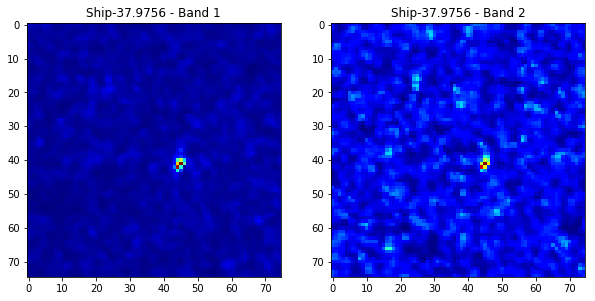

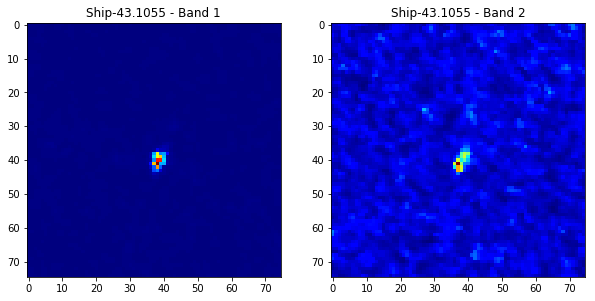

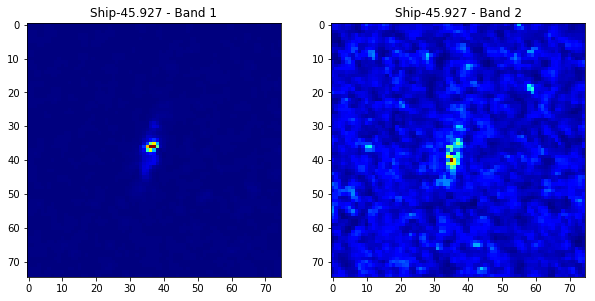

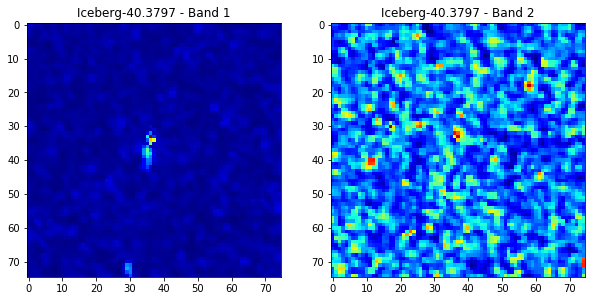

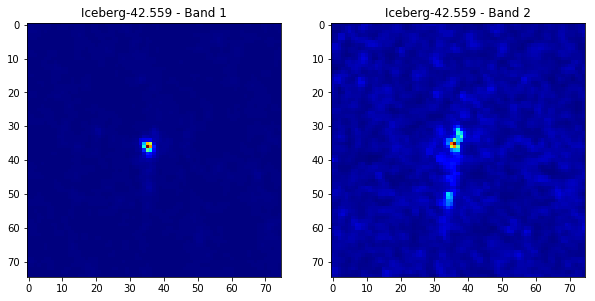

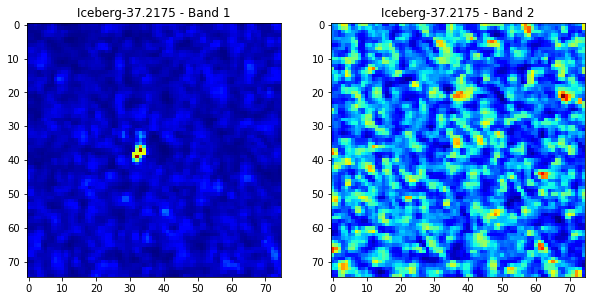

In [137]:
display_img_index(92, True, idx=finite_idx)
display_img_index(95, True, idx=finite_idx)
display_img_index(153, True, idx=finite_idx)
display_img_index(215, True, idx=finite_idx)
display_img_index(239, True, idx=finite_idx)
display_img_index(275, True, idx=finite_idx)

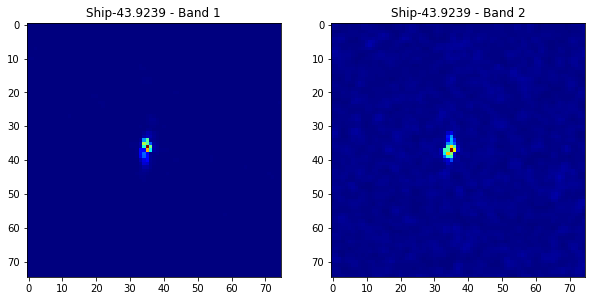

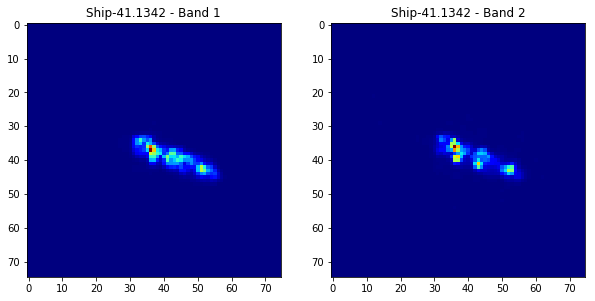

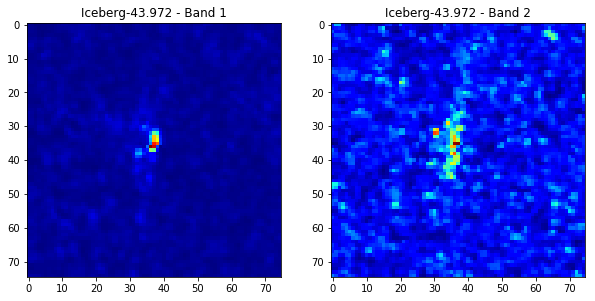

In [139]:
display_img_index(0, True)
display_img_index(100, True)
display_img_index(131, True)

True:  Ship ; False:  Iceberg


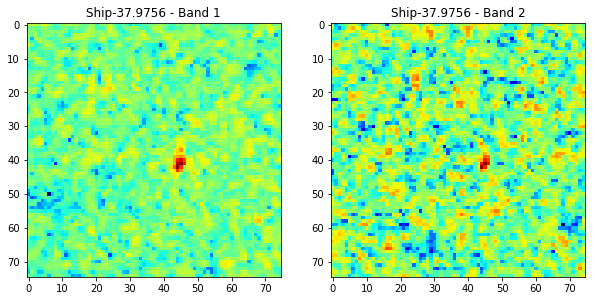

True:  Ship ; False:  Iceberg


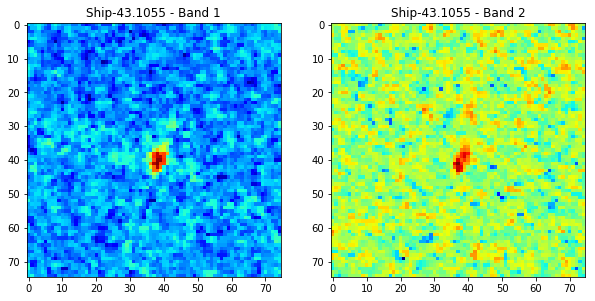

True:  Ship ; False:  Iceberg


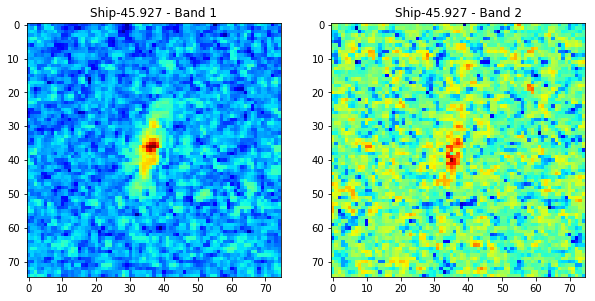

True:  Iceberg ; False:  Ship


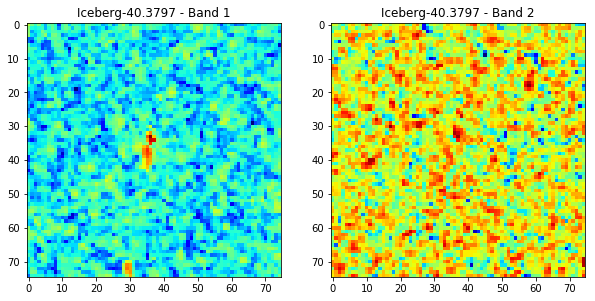

True:  Iceberg ; False:  Ship


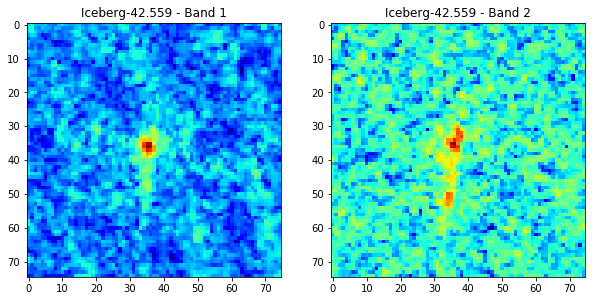

True:  Iceberg ; False:  Ship


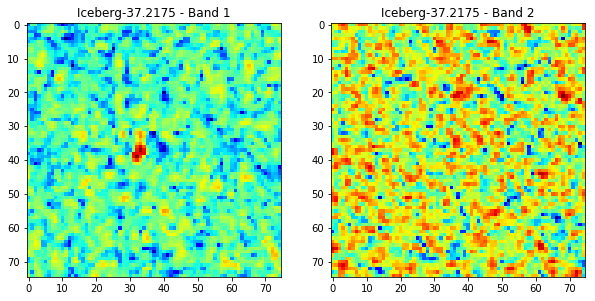

In [136]:
display_mis_pred(0, result_set=y_valid_pred, idx=finite_idx)
display_mis_pred(1, result_set=y_valid_pred, idx=finite_idx)
display_mis_pred(2, result_set=y_valid_pred, idx=finite_idx)
display_mis_pred(3, result_set=y_valid_pred, idx=finite_idx)
display_mis_pred(4, result_set=y_valid_pred, idx=finite_idx)
display_mis_pred(5, result_set=y_valid_pred, idx=finite_idx)